<a href="https://colab.research.google.com/github/romenmeitei/Dengue-cases-in-Manipur/blob/main/Climate_data_acquisition_using_shape_file_of_Manipur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizaton of the shape file

In [7]:
# Install geemap (if not installed)
try:
    import geemap
except ImportError:
    !pip install geemap

import ee
import geemap

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='woven-name-441217-g5')

# Load the shapefile from GEE assets
manipur = ee.FeatureCollection("projects/woven-name-441217-g5/assets/Manipur_shapefile")

# Create a map centered around Manipur
Map = geemap.Map(center=[24.5, 94.0], zoom=7)

# Add the shapefile as a layer
Map.addLayer(manipur, {'color': 'red'}, "Manipur Shapefile")

# Display the map
Map


Map(center=[24.5, 94.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [3]:
import ee

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()  # This will prompt you to authenticate
    ee.Initialize(project='woven-name-441217-g5')

# Load the shapefile from GEE assets
manipur = ee.FeatureCollection("projects/woven-name-441217-g5/assets/Manipur_shapefile")

# Print to check if it's loaded correctly
print(manipur.getInfo())


{'type': 'FeatureCollection', 'columns': {'Country': 'String', 'Dist_Code': 'String', 'Dist_Name': 'String', 'REMARKS_2': 'String', 'State_Code': 'String', 'State_Name': 'String', 'system:index': 'String'}, 'version': 1741875217222359, 'id': 'projects/woven-name-441217-g5/assets/Manipur_shapefile', 'properties': {'system:asset_size': 45004}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[93.70147609127531, 24.620694555457007], [93.70121742514213, 24.624912883410346], [93.69565692624741, 24.66354211242735], [93.6884599586326, 24.711579960984775], [93.6702846595096, 24.781895547051658], [93.64906375146624, 24.787206379027307], [93.62169826797889, 24.803263566894376], [93.60355421319373, 24.815160490951342], [93.6002767615832, 24.821412075480634], [93.59255362100897, 24.82944297379134], [93.59046229931212, 24.826763056488957], [93.57677726819722, 24.825875650486793], [93.57469486757726, 24.816649815469756], [93.5681578472044, 24.81605668418726], [93.559

# Climate data acquisition

Data Summary:
       Temperature (°C)  Precipitation (mm)         NDVI
count         72.000000           72.000000    72.000000
mean          23.835734          120.043194  6875.230419
std            3.904693          101.517967  1301.452706
min           15.736615            1.876447  2160.972801
25%           21.065678           27.085293  6435.278101
50%           25.200027          106.977581  7019.090987
75%           26.685699          194.800678  7862.281466
max           28.916307          384.853854  8533.066296


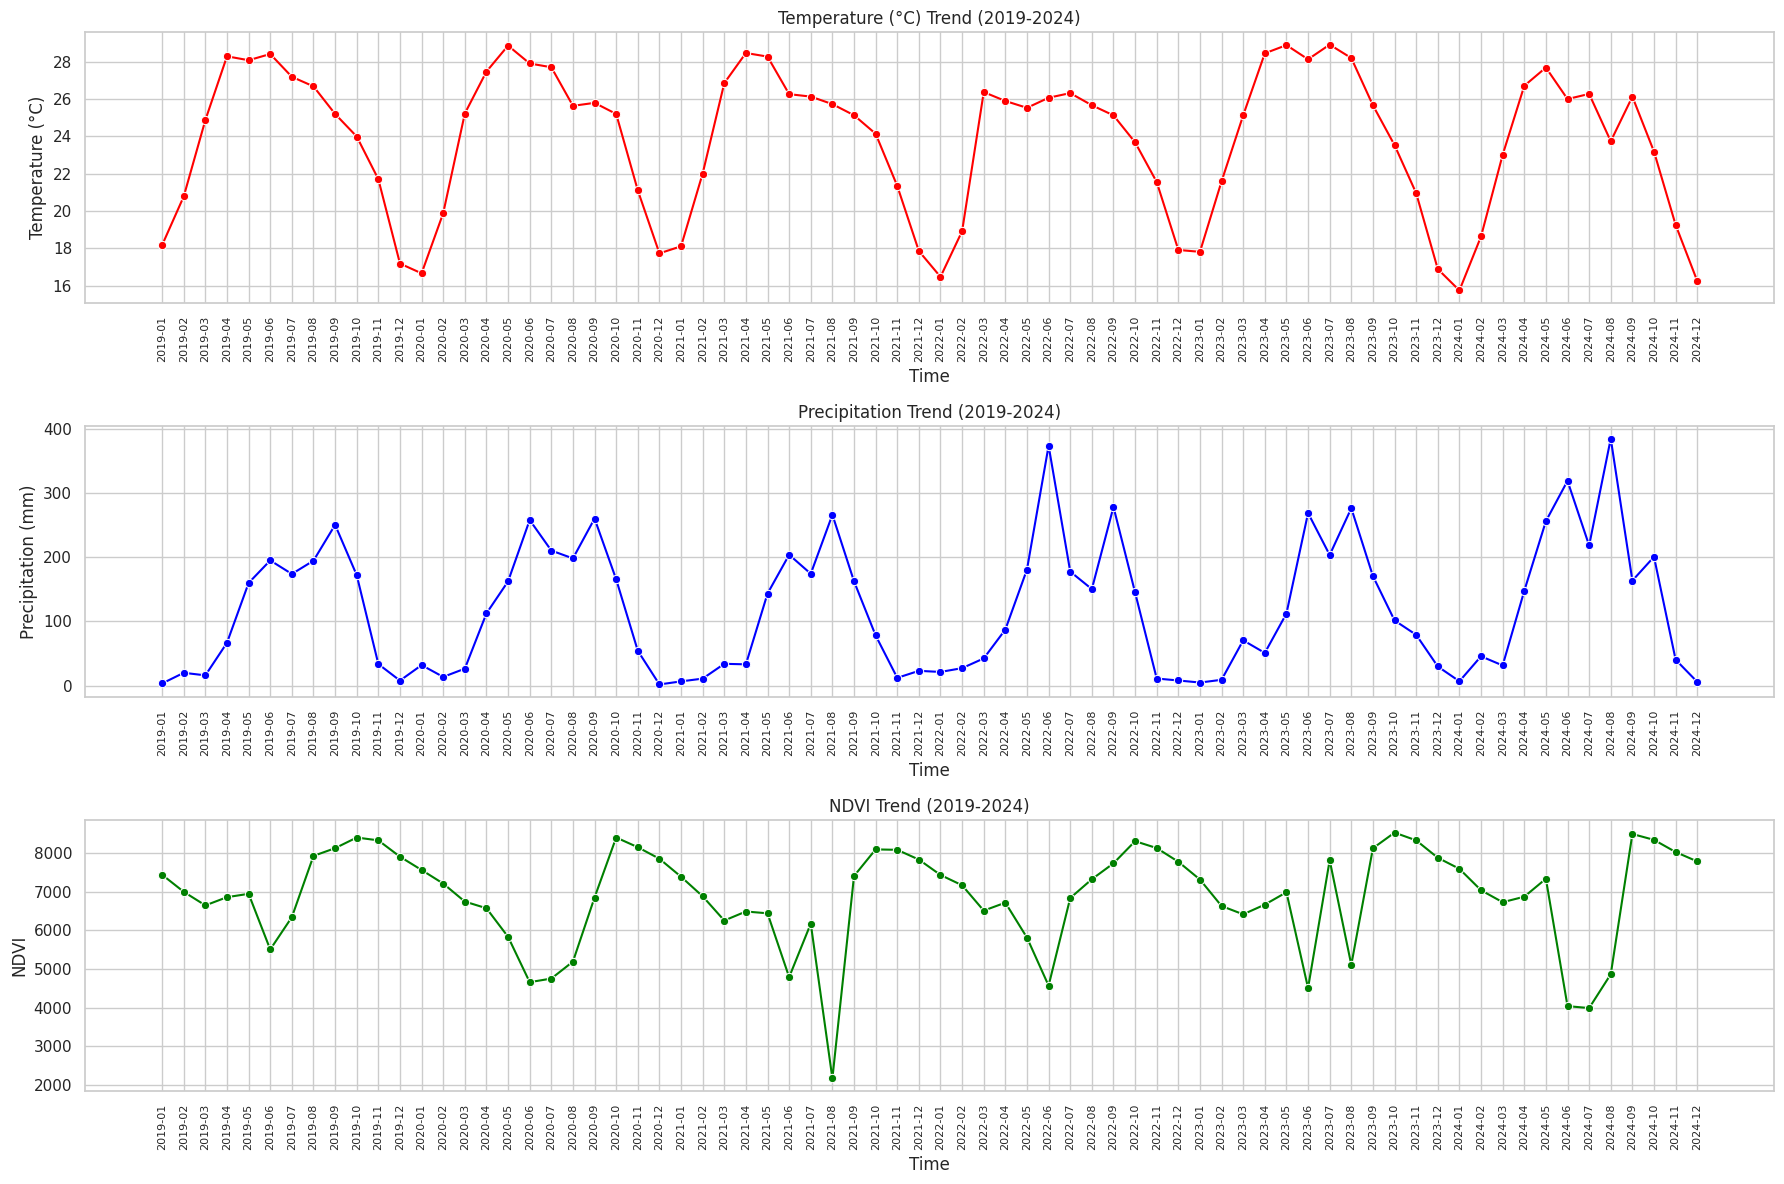

In [38]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='woven-name-441217-g5')

# Define the region of interest (ROI) with updated coordinates
roi = ee.FeatureCollection("projects/woven-name-441217-g5/assets/Manipur_shapefile")

# Define the study period
start_year = 2019
end_year = 2024
months = range(1, 13)

# Initialize lists for storing data
temperature_data, precipitation_data, ndvi_data, time_labels = [], [], [], []

# Function to fetch MODIS LST (temperature)
def get_temperature(year, month):
    dataset = ee.ImageCollection("MODIS/061/MOD11A2").filterDate(
        f"{year}-{month:02d}-01", f"{year}-{month:02d}-28"
    ).filterBounds(roi)

    if dataset.size().getInfo() > 0:
        lst_day = dataset.select("LST_Day_1km").mean().multiply(0.02).subtract(273.15)
        lst_mean = lst_day.reduceRegion(
            reducer=ee.Reducer.mean(), geometry=roi, scale=1000, maxPixels=1e13
        )
        return lst_mean.getInfo().get("LST_Day_1km", None)
    else:
        return None

# Function to fetch CHIRPS precipitation data
def get_precipitation(year, month):
    dataset = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate(
        f"{year}-{month:02d}-01", f"{year}-{month:02d}-28"
    ).filterBounds(roi)

    precipitation = dataset.select("precipitation").sum()
    precipitation_mean = precipitation.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=5000, maxPixels=1e13
    )
    return precipitation_mean.getInfo().get("precipitation", None)

# Function to fetch MODIS NDVI
def get_ndvi(year, month):
    dataset = ee.ImageCollection("MODIS/061/MOD13A2").filterDate(
        f"{year}-{month:02d}-01", f"{year}-{month:02d}-28"
    ).filterBounds(roi)
    ndvi = dataset.select("NDVI").mean()
    ndvi_mean = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=500, maxPixels=1e13
    )
    return ndvi_mean.getInfo().get("NDVI", None)

# Fetch data for each year and month
for year in range(start_year, end_year + 1):
    for month in months:
        temperature_data.append(get_temperature(year, month) or np.nan)
        precipitation_data.append(get_precipitation(year, month) or np.nan)
        ndvi_data.append(get_ndvi(year, month) or np.nan)
        time_labels.append(f"{year}-{month:02d}")

# Create a DataFrame
df = pd.DataFrame({
    "Time": time_labels,
    "Temperature (°C)": temperature_data,
    "Precipitation (mm)": precipitation_data,
    "NDVI": ndvi_data
})

# missing data using Median Instead of Mean –
df["Temperature (°C)"].fillna(df["Temperature (°C)"].median(), inplace=True)



# Summary
print("Data Summary:")
print(df.describe())

# Plotting with Seaborn for improved aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 12))

# Temperature
plt.subplot(3, 1, 1)
sns.lineplot(x="Time", y="Temperature (°C)", data=df, marker="o", color="red")
plt.title("Temperature (°C) Trend (2019-2024)")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Temperature (°C)")
plt.grid(True)

# Precipitation
plt.subplot(3, 1, 2)
sns.lineplot(x="Time", y="Precipitation (mm)", data=df, marker="o", color="blue")
plt.title("Precipitation Trend (2019-2024)")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Precipitation (mm)")
plt.grid(True)

# NDVI
plt.subplot(3, 1, 3)
sns.lineplot(x="Time", y="NDVI", data=df, marker="o", color="green")
plt.title("NDVI Trend (2019-2024)")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("NDVI")
plt.grid(True)

plt.tight_layout()
plt.show()


In [39]:
df.to_csv("generated_climate_data.csv", index=False)
from google.colab import files
files.download("generated_climate_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>